<a href="https://colab.research.google.com/github/gustavo-moretto/WebScrapping_ImoveisCuritiba/blob/main/imoveis_curitiba_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [211]:
class database_imoveis():

  def __init__(self, n_paginas):
    self.n_paginas = n_paginas

  def analise_imoveis( self, 
                    comprar_alugar=['aluguel', 'venda'], 
                    tipos_imoveis = ['apartamento_residencial', 'casa_residencial', 'condominio_residencial', 'cobertura_residencial', 'flat_residencial', 'kitnet_residencial', 'sobrado_residencial']):

    import requests
    import pandas as pd
    from time import sleep
    from bs4 import BeautifulSoup

    import seaborn as sns
    import matplotlib.pyplot as plt    

    from google.colab import files
    from datetime import date 

    conjunto_imoveis = {}
    c = 0
    for negocio in comprar_alugar:
      for pagina in range( self.n_paginas ):
          for tipo_imovel in tipos_imoveis:
            sleep(1)  
            # faz a requisição do site e verifica se esta foi bem-sucedida
            req = requests.get(f"https://www.vivareal.com.br/{negocio}/parana/curitiba/{tipo_imovel}/?pagina={pagina}")

            if req.status_code == 200:
                #print(f'Pag. {pagina}: Requisição bem sucedida!')
                content = req.content
            else:
              print(req.status.code)
              break
              
            # lê o arquivo html com a biblioteca BeautifulSoup
            soup = BeautifulSoup(content, 'html.parser')
              
            # seleciona os dados dos imóveis
            # para isso, encontramos todas as tags <a> com a "class" = "property-card__content-link js-card-title"
            imoveis = soup.find_all('a', attrs={'class':"property-card__content-link js-card-title"})
              
            for imovel in range(len(imoveis)):        
                c += 1
                  
                indice_imovel = c
                # extrai a descrição do imóvel
                #descricao = imoveis[imovel].find("span", attrs={"class":"property-card__title js-cardLink js-card-title"}).text                 

                # extrai o endereço e o bairro do imóvel
                endereco = imoveis[imovel].find("span", attrs={"class":"property-card__address"}).text
                end_completo = endereco

                for elemento in range(len(endereco.split())):
                    if endereco.split()[elemento] == '-':
                        end = endereco.split()[elemento + 1]                  

                        # bairros com nomes compostos -> dessa forma, o nome eh extraido da maneira correta                 
                        if end in ['Santa', 'Sitio', 'Cristo', 'Vista', 'Boa', 'Água', 'Cidade', 'Campo', 'Capão']:
                          endereco = endereco.split()[elemento + 1] + ' ' + endereco.split()[elemento + 2]
                          # excluir a virgula do final do bairro
                          endereco = endereco[:-1]                    
                        elif end == 'Alto':
                          endereco = endereco.split()[elemento + 1] + ' ' + endereco.split()[elemento + 2] + ' ' + endereco.split()[elemento + 3]
                          # excluir a virgula do final do bairro
                          endereco = endereco[:-1]
                        
                        # caso nao haja o nome da rua, o bairro sera igual a 'PR'
                        # para extrair o bairro, devemos extrair o primeiro elemento da lista
                        elif end == 'PR':
                          endereco = endereco.split()[0][:-1]
                        else:
                          endereco = endereco.split()[elemento + 1]
                          # excluir a virgula do final do bairro
                          endereco = endereco[:-1]
                        break
                # extrai a área do imóvel (m²)
                # como existem imoveis com a area variavel, p. ex. 20-30, criei uma excecao
                # neste caso, a area do imovel sera igual a 0
                # creio que isso traz mais realidade ao dataset tambem
                try:
                  area_m2 = float(imoveis[imovel].find("span", attrs={"class":"property-card__detail-value js-property-card-value property-card__detail-area js-property-card-detail-area"}).text)
                except ValueError:
                  area_m2 = 0

                # extrai os itens do imóvel, como mobília, churrasqueira, academia...
                #try:
                    #itens = imoveis[imovel].find("ul", attrs={"class":"property-card__amenities"}).text.split()
                #except AttributeError:
                    #itens = []
                #try:
                    #if itens[-1] == '...':
                        #itens = itens[:-1]
                  #except IndexError:
                      #pass

                # número de comodos (caso não possua vaga de garagem, por exemplo, será atribuído valor 0)
                comodos = []
                try:
                    for k in imoveis[imovel].find_all("span", attrs={"class":"property-card__detail-value js-property-card-value"}):
                        comodos.append(float(k.text))
                except ValueError:
                    comodos.append(0)
                if len(comodos) == 3:
                  quartos = float(comodos[0])
                  banheiros = float(comodos[1])
                  vagas = float(comodos[2])
                else:
                  quartos = 0
                  banheiros = 0
                  vagas = 0

                # extrai o valor do aluguel
                try: 
                  preco = imoveis[imovel].find("p", attrs={'style':"display: block;"}).text                                                                                         
                  try:          
                    if (negocio == 'aluguel' and len(preco.split()[1]) >= 5):            
                      preco = float(preco.split()[1])      
                      preco = preco * 1000                    
                    elif negocio == 'venda' and len(preco.split()) == 2:
                      preco = float(preco.split()[1])
                      preco = preco * 1000                    
                    elif negocio == 'venda' and len(preco.split()) == 6:
                      preco = float(preco.split()[1])
                      preco = preco * 1000                    
                    elif negocio == 'venda' and len(preco.split()) == 5:
                      preco = float(preco.split()[4])
                      preco = preco * 1000                    
                    else:
                      preco = preco.split()[1]
                      if negocio == 'aluguel' and len(preco) == 3:                        
                        preco = preco.replace('.', '')
                        preco = float(preco)
                      else:
                        preco = float(preco)                    
                        preco = preco * 1000                                                      
                  except ValueError:
                    preco = imoveis[imovel].find("p", attrs={'style':"display: block;"}).text
                    preco = preco.replace('.', '')            
                    preco = float(preco.split()[1])
                except AttributeError:                                
                  preco = 0                     

                # extrai o valor do condominio (se não existir, será 0)
                # no laco, caso o valor do condominio seja superior a 999.99 reais, sera multiplicado por 1000
                try:
                    condominio = imoveis[imovel].find("strong", attrs={'class':"js-condo-price"}).text
                    if len(condominio.split()[1]) == 3:
                      condominio = float(condominio.split()[1])
                    else:
                      condominio = float(condominio.split()[1])*1000             
                except AttributeError or ValueError:
                    condominio = 0

                conjunto_imoveis[c] = (negocio, tipo_imovel, indice_imovel, end_completo, endereco, area_m2, quartos, banheiros, vagas, preco, condominio)

    self.df = pd.DataFrame.from_dict(conjunto_imoveis)
    self.df = self.df.T
    self.df = self.df.rename(columns={ 0:'comprar_alugar', 1:'tipo_imovel', 2:'indice', 3:'end_completo', 4:'bairro', 5:'area_m2', 6:'quartos', 7:'banheiros', 8:'vagas_garagem', 9:'preco', 10:'condominio'})
    
    colunas_float = ['area_m2', 'quartos', 'banheiros', 'vagas_garagem', 'preco', 'condominio']
    for coluna in colunas_float: 
      self.df[coluna] = self.df[coluna].astype( float )
        
    print(f'Base de dados criada: {len(self.df)} imoveis cadastrados.')

    # download da base de dados
    download_basedados = str(input('Deseja fazer o download da base de dados [s/n]: '))
    if download_basedados.upper() == 'S':
      today = date.today()
      print(f'Download do arquivo df_imoveis_{today}.csv')
      self.df.to_csv(f'df_imoveis_{today}.csv')
      files.download(f'df_imoveis_{today}.csv')
    else:
      print('Base de dados nao foi baixada.')

    return self.df

In [212]:
database = database_imoveis(1)
df = database.analise_imoveis()
df.head()

Base de dados criada: 490 imoveis cadastrados.
Deseja fazer o download da base de dados [s/n]: n
Base de dados nao foi baixada.


,comprar_alugar,tipo_imovel,indice,end_completo,bairro,area_m2,quartos,banheiros,vagas_garagem,preco,condominio
1,aluguel,apartamento_residencial,1,"Rua Manoel Eufrásio, 1231 - Juvevê, Curitiba - PR",Juvevê,40.00000,1.00000,1.00000,1.00000,2600.00000,550.00000
2,aluguel,apartamento_residencial,2,"Rua Tijucas do Sul, 2680 - Sitio Cercado, Curi...",Sitio Cercado,60.00000,2.00000,1.00000,1.00000,1100.00000,300.00000
3,aluguel,apartamento_residencial,3,"Rua Francisco Rocha, 1777 - Bigorrilho, Curiti...",Bigorrilho,155.00000,4.00000,4.00000,2.00000,2500.00000,980.00000
4,aluguel,apartamento_residencial,4,"Rua Silveira Peixoto, 613 - Água Verde, Curiti...",Água Verde,68.00000,2.00000,1.00000,0.00000,1300.00000,0.00000
5,aluguel,apartamento_residencial,5,"Rua Alferes Ângelo Sampaio - Bigorrilho, Curit...",Bigorrilho,82.00000,3.00000,2.00000,1.00000,6000.00000,360.00000


# Imports

In [213]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 490 entries, 1 to 490
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   comprar_alugar  490 non-null    object 
 1   tipo_imovel     490 non-null    object 
 2   indice          490 non-null    object 
 3   end_completo    490 non-null    object 
 4   bairro          490 non-null    object 
 5   area_m2         490 non-null    float64
 6   quartos         490 non-null    float64
 7   banheiros       490 non-null    float64
 8   vagas_garagem   490 non-null    float64
 9   preco           490 non-null    float64
 10  condominio      490 non-null    float64
dtypes: float64(6), object(5)
memory usage: 45.9+ KB


In [215]:
# criarei uma coluna de vendas e uma coluna de aluguel que receberao os valores 0 caso a afirmativa seja falsa
# e recebera 1 caso a afirmativa seja verdadeira
# estas colunas ajudarao na analise dos dados
df['venda'] = df['comprar_alugar'].apply( lambda x: 1 if x == 'venda' else 0)
df['aluguel'] = df['comprar_alugar'].apply( lambda x: 1 if x == 'aluguel' else 0)

df.head()

,comprar_alugar,tipo_imovel,indice,end_completo,bairro,area_m2,quartos,banheiros,vagas_garagem,preco,condominio,venda,aluguel
1,aluguel,apartamento_residencial,1,"Rua Manoel Eufrásio, 1231 - Juvevê, Curitiba - PR",Juvevê,40.00000,1.00000,1.00000,1.00000,2600.00000,550.00000,0,1
2,aluguel,apartamento_residencial,2,"Rua Tijucas do Sul, 2680 - Sitio Cercado, Curi...",Sitio Cercado,60.00000,2.00000,1.00000,1.00000,1100.00000,300.00000,0,1
3,aluguel,apartamento_residencial,3,"Rua Francisco Rocha, 1777 - Bigorrilho, Curiti...",Bigorrilho,155.00000,4.00000,4.00000,2.00000,2500.00000,980.00000,0,1
4,aluguel,apartamento_residencial,4,"Rua Silveira Peixoto, 613 - Água Verde, Curiti...",Água Verde,68.00000,2.00000,1.00000,0.00000,1300.00000,0.00000,0,1
5,aluguel,apartamento_residencial,5,"Rua Alferes Ângelo Sampaio - Bigorrilho, Curit...",Bigorrilho,82.00000,3.00000,2.00000,1.00000,6000.00000,360.00000,0,1


# Analise Descritiva de Dados

In [216]:
df.describe(include='all')

,comprar_alugar,tipo_imovel,indice,end_completo,bairro,area_m2,quartos,banheiros,vagas_garagem,preco,condominio,venda,aluguel
count,490,490,490.00000,490,490,490.00000,490.00000,490.00000,490.00000,490.00000,490.00000,490.00000,490.00000
unique,2,7,490.00000,419,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,venda,apartamento_residencial,1.00000,"Santa Felicidade, Curitiba - PR",Centro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,252,72,1.00000,5,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,143.40204,2.50612,2.47347,1.84286,456883.47347,1614.57959,0.51429,0.48571
std,NaN,NaN,NaN,NaN,NaN,149.30863,1.23884,1.54295,1.69620,874090.19025,9382.90907,0.50031,0.50031
min,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,NaN,NaN,NaN,NaN,NaN,41.25000,1.00000,1.00000,1.00000,2912.50000,0.00000,0.00000,0.00000
50%,NaN,NaN,NaN,NaN,NaN,110.00000,3.00000,2.00000,2.00000,134000.00000,238.50000,1.00000,0.00000
75%,NaN,NaN,NaN,NaN,NaN,198.00000,3.00000,3.00000,2.00000,600000.00000,600.00000,1.00000,1.00000


In [217]:
# EDA dividida por tipo de negocio -> aluguel
df[df['comprar_alugar'] == 'aluguel'].describe()

,area_m2,quartos,banheiros,vagas_garagem,preco,condominio,venda,aluguel
count,238.00000,238.00000,238.00000,238.00000,238.00000,238.00000,238.00000,238.00000
mean,146.63866,2.51681,2.32353,1.84454,14965.97899,2287.62605,0.00000,1.00000
std,155.33776,1.26863,1.46418,1.66529,94476.92766,10561.64053,0.00000,0.00000
min,15.00000,0.00000,0.00000,0.00000,450.00000,0.00000,0.00000,1.00000
25%,45.00000,1.00000,1.00000,1.00000,1500.00000,0.00000,0.00000,1.00000
50%,101.00000,3.00000,2.00000,2.00000,2850.00000,300.00000,0.00000,1.00000
75%,191.00000,3.00000,3.00000,2.00000,4600.00000,717.50000,0.00000,1.00000
max,1440.00000,8.00000,7.00000,8.00000,970000.00000,85000.00000,0.00000,1.00000


A media dos alugueis e de mais de R$ 200.000,00, o que sabemos que e impossivel.
Podemos perceber uma diferenca muito grande da mediana com a media e ate mesmo do terceiro quartil em relacao a media.

Plotaremos um boxplot para nos auxiliar a enxergamos a distribuicao do valor dos alugueis e estabelecermos qual atitude devemos tomar.

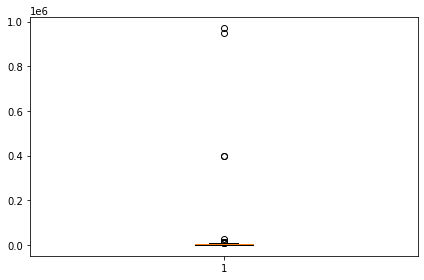

In [218]:
df_aluguel = df[df['comprar_alugar'] == 'aluguel']
plt.boxplot( x=df_aluguel['preco'] );
plt.tight_layout()

Temos muitos outliers neste grafico.
Talvez o melhor a fazer seja excluidos da base de dados.
Para isso, irei ver quantos registros estao acima do limite superior do nosso boxplot, utilizando a formula:
Limite_Superior = Q3 + 1.5 * (Q3 - Q1)

In [219]:
q1 = 1800
q3 = 6500

lim_sup = q3 + 1.5*(q3 - q1)

display(df_aluguel[df_aluguel['preco'] > lim_sup])

,comprar_alugar,tipo_imovel,indice,end_completo,bairro,area_m2,quartos,banheiros,vagas_garagem,preco,condominio,venda,aluguel
51,aluguel,casa_residencial,51,"Rua Júlia Huga Maria Negrello, 291 - Centro, C...",Centro,191.00000,3.00000,3.00000,2.00000,970000.00000,470.00000,0,1
57,aluguel,casa_residencial,57,"Rua Hermes Fontes, 1010 - Batel, Curitiba - PR",Batel,500.00000,4.00000,5.00000,6.00000,15000.00000,0.00000,0,1
59,aluguel,casa_residencial,59,"Vista Alegre, Curitiba - PR",Vist,1000.00000,5.00000,6.00000,8.00000,15000.00000,0.00000,0,1
62,aluguel,casa_residencial,62,"Rua Guaianazes, 550 - Centro, Curitiba - PR",Centro,250.00000,3.00000,4.00000,4.00000,950000.00000,0.00000,0,1
87,aluguel,condominio_residencial,87,"Alameda das Buganvílias - Mossunguê, Curitiba ...",Mossunguê,700.00000,5.00000,7.00000,3.00000,27000.00000,670.00000,0,1
154,aluguel,flat_residencial,154,"Rua Constantino Marochi, 1342 - Alto da Glória...",Alto da Glória,27.00000,1.00000,1.00000,0.00000,400000.00000,0.00000,0,1
155,aluguel,flat_residencial,155,"Rua Constantino Marochi, 1342 - Alto da Glória...",Alto da Glória,27.00000,1.00000,1.00000,0.00000,400000.00000,0.00000,0,1
234,aluguel,sobrado_residencial,234,Rua Padre Francisco João Azevedo - Jardim Botâ...,Jardi,1440.00000,5.00000,7.00000,6.00000,15000.00000,0.00000,0,1


In [191]:
len(df_aluguel)

4780

In [185]:
# EDA dividida por tipo de negocio -> venda
df[df['comprar_alugar'] == 'venda'].describe()

,area_m2,quartos,banheiros,vagas_garagem,preco,condominio,venda,aluguel
count,5040.00000,5040.00000,5040.00000,5040.00000,5040.00000,5040.00000,5040.00000,5040.00000
mean,143.68611,2.51687,2.63690,1.86448,859290.40853,983.39722,1.00000,0.00000
std,144.32682,1.24308,1.58390,1.78261,981294.00092,8163.32505,0.00000,0.00000
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
25%,38.00000,1.00000,1.00000,1.00000,275000.00000,0.00000,1.00000,0.00000
50%,117.00000,3.00000,3.00000,2.00000,590000.00000,0.00000,1.00000,0.00000
75%,212.00000,3.00000,4.00000,2.00000,999999.00000,540.00000,1.00000,0.00000
max,1150.00000,8.00000,8.00000,15.00000,8200000.00000,125000.00000,1.00000,0.00000


In [146]:
# Imoveis p/ vender vs Imoveis p/ alugar

print('Imoveis a Venda vs Imoveis p/ Alugar')
df[['comprar_alugar', 'tipo_imovel']].groupby('comprar_alugar').count()

Imoveis a Venda vs Imoveis p/ Alugar


,tipo_imovel
comprar_alugar,
aluguel,4780
venda,5040


In [175]:
# Imoveis por tipo: Aluguel vs Venda

print('Imoveis por tipo: Aluguel vs Venda')
df[['tipo_imovel', 'venda', 'aluguel']].groupby('tipo_imovel').sum()

Imoveis por tipo: Aluguel vs Venda


,venda,aluguel
tipo_imovel,,
apartamento_residencial,720,720
casa_residencial,720,720
cobertura_residencial,720,720
condominio_residencial,720,720
flat_residencial,720,460
kitnet_residencial,720,720
sobrado_residencial,720,720


In [164]:
df[df['comprar_alugar'] == 'venda'].groupby('tipo_imovel').agg({'preco': ['mean', 'min', 'max', 'std']})

preco                                         
                                 mean          min           max           std
tipo_imovel                                                                   
apartamento_residencial  681871.43472 125000.00000 3799000.00000  658310.77867
casa_residencial        1234159.58333   3200.00000 8200000.00000 1457120.41677
cobertura_residencial   1274559.41667   2500.00000 7200000.00000  927046.79730
condominio_residencial  1583123.86667      0.00000 6700000.00000 1261112.31559
flat_residencial         283447.22222 115000.00000  450000.00000   89560.08833
kitnet_residencial       217001.36389 109000.00000  451200.00000   81778.70134
sobrado_residencial      740869.97222 120000.00000 1520000.00000  314158.28845